# FILTERING THE DATASET:

Along this script we will get from an initial list of products provided by our client, to a final list (as per the names and ids present within the real data), which will be used to filter our initial data in order to get a smaller, more manageable file.

This process will be divided in two main steps:

- Check the names in our list with the descriptions present in our data, analyze them and select a final list

- Use this list to filter our data and store the resulting information in a more small and convenient file

## CREATING THE LIST OF PRODUCTS FOR THE ANALYSIS:

After rearranging the data in a more convenient manner and doing some introductory analysis of the data, we now want to get down to work with our data.

A list has been given to us of the 10 products that our clients found as more relevant to their business.

What we want now is to check whether the names on the list correspond to certain uniques ids, or, as seen in the previous scripts, some conflict of unicity will arise between the id of our products and their descriptions.

So, we are going to check our dataframe and select from it the ids and descriptions of our products that match the indications given in our clients list. With the lists (in reality, two dictionaries) of the ids and descriptions that match every product given to us, we will decide which are the more appropriate.

Perhaps some guidance from our client would be needed at this stage.

### 1. Read dataframe

In [1]:
# Importing packages:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from collections import Counter
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import math
import seaborn as sns


%matplotlib inline
pd.options.display.max_columns = None

/Users/miruiz/kschool-final-project/lib/python2.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
# Defining the search path of the file, the name and the separator:

file_path = "../../data/01_raw/"
file_name = "b2-transactions.csv" #'b2-transactions_sample.csv' 
exit_path = "../../data/02_intermediate/"

filtered_file_name="c1-filtered_transactions.csv"

sep=";"

In [3]:
# We create the list of products provided by the client
list_of_products=['croissant',
                  'croissant petit',
                  'tarta mousse 3 chocolates',
                  'tarta de manzana 2º',
                  'palmera de chocolate'
                  'tarta opera',
                  'postre fresas y mascarpone',
                  'milhojas frambuesa 2º',
                  'tortel',
                  'baguette']

In [4]:
# We import the dataframe:
df=pd.read_csv(file_path+file_name, sep=sep)

In [5]:
df.sample(5)

,product_id,description,order_date,section,store,units_ordered
16951106,458.0,S.HONORET CREMA-TRUFA 3º,9/3/2008 0:00:00,0,GoUP,"0,00"
17584418,3301.0,CREMA DE ESPINACAS,7/1/2016 0:00:00,0,GoUP,"0,00"
18271266,865.0,POSTRE OPERA,23/5/2010 0:00:00,0,GrUP,"0,00"
1513341,101.0,CROISSANT,29/5/2016 0:00:00,0,BmUP,"0,00"
1640037,502.0,SABLE CHOCOLATE,22/7/2012 0:00:00,0,VeUp,"1,00"


### 2. Normalizing and aggregating description names

Unfortunately, there is no convention for the description and one id could 

1. Normalize descriptions as much as possible using:
    - Regex expressions 
    - Basic NLP for spell-checking.
2. Create a normalization file with the following structure:
    - Unique Product_id and normalized description
    - Flag to indicate if the product is part of the given list, or not.  
3. Finally review the list manually. 

### 2.1 Normalizing description names 

In [6]:
# Setting Null descriptions to 'no-description'
df['description'].fillna('no-description', inplace = True)

# Unique product descriptions
df_descriptions_unique = pd.Series(df['description'].unique())

# Most of the descriptions are in uppercase, however others are in lower:
df_descriptions_normalized = df_descriptions_unique.str.lower()

#replace non alfanumeric with space
df_descriptions_normalized=df_descriptions_normalized.str.replace(r'[^0-9a-zA-Zº()ª:-]+', ' ') 

# We also notice that there are spacing issues at the begining, end of the description and between words:
df_descriptions_normalized=df_descriptions_normalized.str.strip()

# Remove multi-spacing. multi '-' and multi ':'
df_descriptions_normalized=df_descriptions_normalized.str.replace(r' +', ' ') 
df_descriptions_normalized=df_descriptions_normalized.str.replace(r'-+', ' ') 
df_descriptions_normalized=df_descriptions_normalized.str.replace(r':+', ' ') 

In [7]:
pd.DataFrame(dict(desc_original = df_descriptions_unique, desc_normalized = df_descriptions_normalized)).sample(10)

,desc_original,desc_normalized
10857,Encargo ROLLITOS DE PRIMAVERA,encargo rollitos de primavera
29049,TARTA COMUNION 4º,tarta comunion 4º
4567,"TARTA TRES CHOCOLATES DE 16 RACIONES,",tarta tres chocolates de 16 raciones
42161,COCA DE CREMA,coca de crema
11722,CORVINA EN SALSA VERDE,corvina en salsa verde
32399,Encargo TARTA CREMA CATALANA Y FOTO CLIENTE,encargo tarta crema catalana y foto cliente
22171,TARTA SELVA NEGRA DE 50 RAC CON EL FONDO EN V...,tarta selva negra de 50 rac con el fondo en ve...
7530,Encargo TARTA MOUSE TRES CHOCOLATES DEL 1 FELI...,encargo tarta mouse tres chocolates del 1 feli...
18767,"Encargo TARTA VIRUTA DE CHOCOLATE DEL 3 ,,FELI...",encargo tarta viruta de chocolate del 3 felici...
38307,Caja de Mini Sándwiches de 5 rac. ( 8 son de e...,caja de mini s ndwiches de 5 rac ( 8 son de en...


Now lets gets get our hands dirty and apply some maths to calculate string distnace and finish cleaning all those messy product descriptions... This is what we are going to do:

1. Create a dataset with pastry products by parsing the bakery catalogues, and other pastry websites. (this was done manually, by converting the pdf catalogues to txt using an external web. THe resulting file is named productos.txt)

2. Following the indications from: https://medium.com/@hdezfloresmiguelangel/implementando-un-corrector-ortogr%C3%A1fico-en-python-utilizando-la-distancia-de-levenshtein-498ec0dd1105 create an spell-checker based on the products.txt dataset and the Levenshtein distance


In [183]:
def words(text): return re.findall(r'\w+', text.lower())

WORDS = Counter(words(open('../../data/01_additional_data/productos.txt').read()))

def P(word, N=sum(WORDS.values())): 
    "Probability of `word`."
    return WORDS[word] / N

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

In [181]:
correction("trta")

'tarta'

In [10]:
correction("café")

'cafe'

Fantastic! the it seems to work. Lets now apply it to our dataset:

In [11]:
def spell_check (line):
    "Given a sentence, returns spell-checks word by word"
    if type(line) == str and len(line) > 0:
        new = []
        line = line.split(" ")
        for word in line:
            if type(word) == str:
                word = correction(word)
            new.append(word)
        return " ".join(new)
            
    else:
        return line

In [12]:
# CAUTION! The following cell e may take a long time to process (5 hours): 

# spell-check word by word the dataset:
df_descriptions_normalized = df_descriptions_normalized.apply(lambda line: spell_check(line))

Lets now merge the normalized names back to the original file, and check how effective was this cleaning:

In [13]:
to_merge = pd.DataFrame(dict(description = df_descriptions_unique, desc_normalized = df_descriptions_normalized))

df_with_normalized_descriptions_transactions = pd.merge(df, to_merge, how='left', on = 'description').sort_values(by='order_date')
df_with_normalized_descriptions_transactions.sample(5)

,product_id,description,order_date,section,store,units_ordered,desc_normalized
16842805,9999.0,EncargoCARDO,20/12/2009 0:00:00,0,GoUP,"0,00",encargocardo
28937085,709.0,CAPUCHINAS,20/12/2016 0:00:00,0,ZiUO,"0,00",capuchina
22351725,9999.0,EncargoDIBUJO DE UNA FOTO TRAIDA POR UN CLIENTE,2/10/2016 0:00:00,0,MoUP,"0,00",encargodibujo de una feo traida con un cliente
2767947,245.0,Sandwiches mixtos,29/5/2015 0:00:00,0,VeUp,"0,00",sandwich minutos
27761506,4510.0,TARTA FRESAS Y MASCARPONE,18/5/2015 0:00:00,0,ZiUO,"0,00",tarta fresas y mascarpone


In [14]:
#Control merge size:
if (df.shape[0] == df_with_normalized_descriptions_transactions.shape[0] ): 
    test0 = "OK - 'df' has the same size as 'df_with_normalized_descriptions_transactions' "
else:
    test0 = "ERROR - 'df' has NOT the same size as 'df_with_normalized_descriptions_transactions' "
print(test0)

OK - 'df' has the same size as 'df_with_normalized_descriptions' 


In [15]:
# Checking effectiveness of the data cleaning:
unique_descriptions_raw = len(df['description'].unique())
unique_descriptions_normalized = len(df_with_normalized_descriptions_transactions['desc_normalized'].unique())
print('The product descritions were cleaned from {} unique names to {}.'.format(unique_descriptions_raw,unique_descriptions_normalized))

The product descritions were cleaned from 48517 unique names to 40024.


Not super effective...

In [16]:
# Saving the file to the intermiady folder
output_path_df_with_normalized_descriptions_transactions = exit_path + 'data_with_normalized_names.csv'
df_with_normalized_descriptions_transactions.to_csv(output_path_df_with_normalized_descriptions_transactions, index = False, sep = ';' )

### 2.2 Identifying product descriptions that the client wants us to predict

It is time to create the file that will be manually reviewed.

- First, we compare the normalized descriptions with the list of products provided with the client, and suggest matches using the library fuzzywuzzy
- Second, we will use the results from the other analysis.
- third, we will manually evaluate if the results are good

#### 2.2.1 Using the library fuzzywuzzy to compare the product normalized descriptions with the list of products provided by the client and suggest a match, or alternatively - "match-not-found"

In [17]:
df_normalized_desc_unique = pd.DataFrame(df_with_normalized_descriptions_transactions["desc_normalized"].unique(), columns = ['desc_normalized'])

In [18]:
def find_match (line, options = list_of_products):
    "Returns product match if the the calculated difference between strings is greater than 80, 'match-not-found' otherwise"
    if not(line is None) and type(line)== str:
        highest = process.extractOne(line,list_of_products)
        if not(highest is None) and highest[1] >80:
            return highest[0]
        else:
            return 'match-not-found'
    else:
        return 'match-not-found'

# Applying matching function to all product normalized descriptions
df_normalized_desc_unique["target_names_fuzzywuuzy"] = df_normalized_desc_unique["desc_normalized"].apply(lambda line: find_match(line))

Lets now evaluate how effectively did we match the normalized descriptions with the list that the client provided us:

In [19]:
# Lets review the effectiveness filtering by 'mousse '. The expected result is that all 'mousse 3 chocolates' match
df_normalized_desc_unique[df_normalized_desc_unique['desc_normalized'].str.contains('mousse')].head(10)

,desc_normalized,target_names_fuzzywuuzy
380,mousse chocolate blanco,match-not-found
417,postres mousse chocolate en vasito,match-not-found
419,postres mousse frutas bosque,match-not-found
482,postres mousse de limon,match-not-found
501,petit yogur mousse praline,croissant petit
569,mousse 3 chocolates 3,tarta mousse 3 chocolates
570,mousse 3 chocolates 1,tarta mousse 3 chocolates
571,mousse 3 chocolates 2,tarta mousse 3 chocolates
572,postres mousse tres chocolates,match-not-found
617,mousse de perigot,palmera de chocolatetarta opera


As we can see... its not actually very good, lets try something different.

#### 2.2.1 Using the results from the other analysis

Lets now use the results from the manual analysis to see how efective the measure was:

In [20]:
# Since this matching is performed at id level, 
# lets create a new dataset with unique product_id, descriptions, and evaluate it:
df_normalized_id_desc_unique = df_with_normalized_descriptions_transactions[["product_id",'desc_normalized']].drop_duplicates()

In [21]:
dict_of_products_matches={100: 'croissant', 
                  101: 'croissant',
                  102: 'croissant',
                  103: 'croissant petit',
                  9999: 'tarta mousse 3 chocolates', # almost only for order, creating a new id for this product is suggested
                  462: 'tarta de manzana 2º',
                  182: 'palmera de chocolate', # palmeras: 140
                  414: 'tarta opera', # 9999, for order, mostly. If included, creating a new id for this product is suggested
                  4511:'postre fresas y mascarpone',
                  459: 'milhojas frambuesa 2º',
                  112: 'tortel',
                  115: 'baguette'}

In [22]:
def target_names_a(product_id, dict_of_products_matches= dict_of_products_matches):
    'Returns match if the product_id is found within the given dict or, otherise "match-not-found"'
    if not(product_id is None) and not(math.isnan(product_id)) and int(product_id)  in dict_of_products_matches:
        return dict_of_products_matches[int(product_id)]
    else:
        return 'match-not-found'
    
df_normalized_id_desc_unique['target_names_manual_analysis']=df_normalized_id_desc_unique["product_id"].apply(lambda line: target_names_a(line))

Lets now check how effective this was:

In [23]:
# Lets review the effectiveness filtering by 'mousse '. The expected result is that all 'mousse 3 chocolates' match
df_normalized_id_desc_unique[df_normalized_id_desc_unique['desc_normalized'].str.contains('mousse')].head(15)

,product_id,desc_normalized,target_names_manual_analysis
2498667,618.0,mousse chocolate blanco,match-not-found
2479507,877.0,postres mousse chocolate en vasito,match-not-found
2479509,879.0,postres mousse frutas bosque,match-not-found
13734845,821.0,postres mousse de limon,match-not-found
13734826,728.0,petit yogur mousse praline,match-not-found
25009569,453.0,mousse 3 chocolates 3,match-not-found
25009568,452.0,mousse 3 chocolates 1,match-not-found
25009567,451.0,mousse 3 chocolates 2,match-not-found
25009566,450.0,postres mousse tres chocolates,match-not-found
24921912,312.0,mousse de perigot,match-not-found


Again, not very good, since most of the 'mousse 3 chocolates' are unmatched.

It is clear that we need an better way to match the results. Lets try doing keywords filtering product by product.

In [6]:
# TO DELETE!
output_path_df_with_normalized_descriptions_transactions = exit_path + 'data_with_normalized_names.csv'
df_with_normalized_descriptions_transactions = pd.read_csv(output_path_df_with_normalized_descriptions_transactions, sep = ';' )


### 2.3 Review Product by Product

In [7]:
#First, lets create again a dataframe with unique descriptions
unique_normalized_decriptions = df_with_normalized_descriptions_transactions[['product_id','desc_normalized']].drop_duplicates()

#And a empty list to add all the unitary analysis. It will be use to concatenate results.
list_of_dfs = []

In [8]:
# Functions that we will use:

def plot_count_per_id(df):
    transactions_by_id = df.groupby("product_id")['desc_normalized'].count()
    transactions_by_id.plot.bar()

#### 2.3.1 Matching: milhojas de frambuesa 2º

In [9]:
def filter_milhojas (df):
    'Filters the product descriptions of given dataset by "milhojas" and "frambuesa 2"'
    milhojas = df[df['desc_normalized'].str.contains('milhojas')]
    milhojas_frambuesa = milhojas[milhojas['desc_normalized'].str.contains('frambuesa 2')].copy()
    return milhojas_frambuesa


In [10]:
# Filter the transactions dataset
milhojas_frambuesa_transacciones=filter_milhojas(df_with_normalized_descriptions_transactions)
milhojas_frambuesa_transacciones.head()

,product_id,description,order_date,section,store,units_ordered,desc_normalized
336,414.0,TARTA MILHOJAS FRAMBUESA 2º,1/1/2008 0:00:00,0,VeUp,"0,00",tarta milhojas frambuesa 2
1129,459.0,MILHOJAS FRAMBUESA 2º,1/1/2008 0:00:00,0,MsUP,"0,00",milhojas frambuesa 2
1322,459.0,MILHOJAS FRAMBUESA 2º,1/1/2008 0:00:00,0,ZiUO,"0,00",milhojas frambuesa 2
1358,459.0,MILHOJAS FRAMBUESA 2º,1/1/2008 0:00:00,0,VeUp,"2,00",milhojas frambuesa 2
1370,414.0,TARTA MILHOJAS FRAMBUESA 2º,1/1/2008 0:00:00,0,ZiUO,"0,00",tarta milhojas frambuesa 2


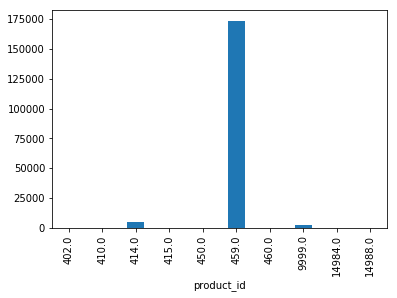

In [11]:
# Plot the ditribution of 'product_id'
plot_count_per_id(milhojas_frambuesa_transacciones)

Lets explore the names distribution of 414, 459 and 9999:

In [12]:
#Names distribution for product_id = 459:
df_with_normalized_descriptions_transactions[df_with_normalized_descriptions_transactions['product_id']==459.0]['desc_normalized'].value_counts().head()

milhojas frambuesa 2                       167542
milhojas frambuesa 1                         1311
tiras de milhojas rellena solo de crema       532
milhojas frambuesa 3                          437
milhojas frambuesa 2 solo crema               399
Name: desc_normalized, dtype: int64

In [13]:
#Names distribution for product_id = 414:
df_with_normalized_descriptions_transactions[df_with_normalized_descriptions_transactions['product_id']==414.0]['desc_normalized'].value_counts().head()

tarta muy tres chocolates 2    4788
tarta milhojas frambuesa 2     4123
tarta limon 3                  3420
tarta milhojas 2               1824
tarta tres chocolates 2        1805
Name: desc_normalized, dtype: int64

In [14]:
#Names distribution for product_id = 9999:
df_with_normalized_descriptions_transactions[(df_with_normalized_descriptions_transactions['product_id']==9999.0) & (df_with_normalized_descriptions_transactions['desc_normalized'].str.contains('milhoja'))]['desc_normalized'].value_counts().head()

tarta milhojas frambuesa 2                  950
tiras de milhojas solo crema                912
encargo tarta milhojas del 1                912
tarta milhojas de frambuesa del 3           855
encargo tarta milhojas y frambuesa del 1    798
Name: desc_normalized, dtype: int64

It seems there is a strong correlation with id 459, however 459 it also includes other types of 'milhojas'. In addition, 'milhojas de frambuesa 2º' is also included in id number 414, which seems to be a multiple 'tartas' id, and id 9999, which is the id used for custom orders.

For these reasons, we decide to filter milhojas based on the description (filtering the dataframe with only disting 'product_id' and 'des_normalized' values:

In [15]:
#Save unique product_id and product_description:
milhojas_frambuesa = filter_milhojas(unique_normalized_decriptions)
milhojas_frambuesa['target_names_prod_by_prod'] = 'milhojas frambuesa'
list_of_dfs.append(milhojas_frambuesa)
milhojas_frambuesa.sample(5)

,product_id,desc_normalized,target_names_prod_by_prod
7200967,459.0,milhojas frambuesa 2 con cartel felix cumplea ...,milhojas frambuesa
1673534,459.0,milhojas frambuesa 2 con cartel de felicidades...,milhojas frambuesa
1821876,459.0,milhojas frambuesa 2 y cartel felicidades masa,milhojas frambuesa
19189836,414.0,tarta milhojas frambuesa 2 felicidades,milhojas frambuesa
26613392,459.0,milhojas frambuesa 2 para cafeteria),milhojas frambuesa


#### 2.3.2 Matching: croissant petite

From the analysis performed in notebook "x01-transactions_to_partial_results-yy.ipynb", it was concluded that 'croissant petite' had an strong correlation with id number '103' however, before commiting to filtering by that ID, lets plot the distribution of count of lines per ID, that satisfies the filters of the following function, from the transaction dataset, in order to :

In [16]:
def filter_croissant_petit (df):
    croissant = df[df['desc_normalized'].str.contains('croissant')].copy()
    croissant_petite = croissant[croissant['desc_normalized'].str.contains('petit')].copy()
    return croissant_petite

In [17]:
# Plotting the results:
transactions_croissant_petite = filter_croissant_petit(df_with_normalized_descriptions_transactions)
transactions_croissant_petite.head()

,product_id,description,order_date,section,store,units_ordered,desc_normalized
242,103.0,CROISSANT PETIT,1/1/2008 0:00:00,0,VeUp,"18,00",croissant petit
314,102.0,PETIT CROISSANTS ALARGADOS FUTBOL,1/1/2008 0:00:00,0,VeUp,"0,00",petit croissant alargados futbol
1368,102.0,PETIT CROISSANTS ALARGADOS FUTBOL,1/1/2008 0:00:00,0,ZiUO,"0,00",petit croissant alargados futbol
1488,103.0,CROISSANT PETIT,1/1/2008 0:00:00,0,ZiUO,"0,00",croissant petit
1579,103.0,CROISSANT PETIT,1/1/2008 0:00:00,0,AeUP,"0,00",croissant petit


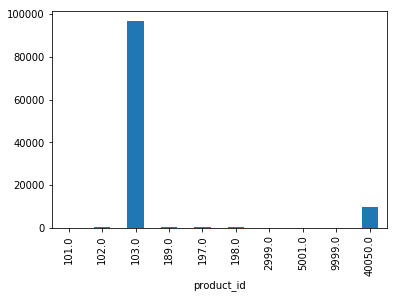

In [18]:
plot_count_per_id(transactions_croissant_petite)

It is clear that id '103' represents the 'croissant petite';  in fact, after reviweing the data with the client, he suggested only taking 103.

In [19]:
# Saving id=103 as croissant petit
croissant_petit = unique_normalized_decriptions[unique_normalized_decriptions['product_id']==103.0].copy()
croissant_petit['target_names_prod_by_prod'] = 'croissant petit'
list_of_dfs.append(croissant_petit)
croissant_petit.head()

,product_id,desc_normalized,target_names_prod_by_prod
242,103.0,croissant petit,croissant petit
331,103.0,mini napolitanas crema,croissant petit
332,103.0,mini napolitanas chocolate,croissant petit
333,103.0,focaccias futbol,croissant petit
89738,103.0,baguet multicereales,croissant petit


#### 2.3.3 Matching: croissant

From the analysis performed in notebook "x01-transactions_to_partial_results-yy.ipynb", it was concluded that 'croissant simple' had an strong correlation with id number '100' and '101' however, before commiting to filtering by that ID, lets plot the distribution of count of lines per ID, that satisfies the filters of the following function, from the transaction dataset, in order to :

In [20]:
def filter_croissant_simple (df):
    croissant = df[df['desc_normalized'].str.contains('croissant')].copy()
    croissant_simple = croissant[~croissant['desc_normalized'].str.contains('petit|tira|masa')].copy()
    return croissant_simple

In [21]:
transactions_croissant_simple = filter_croissant_simple(df_with_normalized_descriptions_transactions)
transactions_croissant_simple.head()

,product_id,description,order_date,section,store,units_ordered,desc_normalized
201,215.0,CROISANNT SOBRASADA PQ COCIDOS,1/1/2008 0:00:00,0,VeUp,"2,00",croissant sobrasada px cocido
216,100.0,CROISANTS,1/1/2008 0:00:00,0,VeUp,"20,00",croissant
240,101.0,CROISSANT,1/1/2008 0:00:00,0,VeUp,"0,00",croissant
241,102.0,CROISSANT FRANCES,1/1/2008 0:00:00,0,VeUp,"10,00",croissant francesa
267,105.0,CROISSANT CHOCOLATE,1/1/2008 0:00:00,0,VeUp,"1,00",croissant chocolate


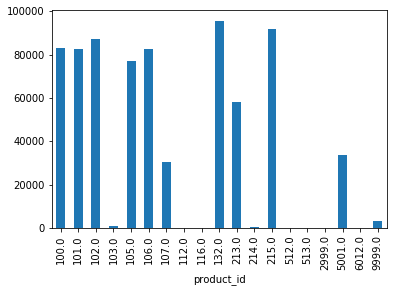

In [22]:
plot_count_per_id(transactions_croissant_simple)

Interesting, the correlation seems to exsit for several ids... Lets explore a bit more... Lets plot the most common description from each id and see if we find any pattern:

In [25]:
for i in transactions_croissant_simple['product_id'].unique():
    to_print = df_with_normalized_descriptions_transactions[df_with_normalized_descriptions_transactions['product_id']==i]['desc_normalized'].value_counts().head()
    print("***Plotting id: {} ".format(i))
    print("-")

    print(to_print)
    print("")


***Plotting id: 215.0 
-
croissant sobrasada px cocido               91580
croissant sobrasada px cocido de encargo       76
croissant sobrasada px cocido encargo          38
mini pizzas                                    19
mini hamburguesitas                            19
Name: desc_normalized, dtype: int64

***Plotting id: 100.0 
-
croissant                       80598
croissant normal mango           1197
croissant alargados piezas        342
croissant piezas alargadas        133
croissant alargados y piezas       95
Name: desc_normalized, dtype: int64

***Plotting id: 101.0 
-
croissant                        72124
croissant andes marcos piezas     8550
suizos piezas hacer 10            4180
ensaimadas piezas hacer 10        3477
tiras de focaccias                2432
Name: desc_normalized, dtype: int64

***Plotting id: 102.0 
-
croissant francesa               86279
croissant andes marcos piezas      703
focaccias                          266
chapatitas ocio                    24

It seems that they have different types of croissant. Checking with the client, he suggested taking only: 100.0 and 101.0 that contains the word 'croissant'

In [26]:
croissant_simple = unique_normalized_decriptions[(unique_normalized_decriptions['product_id']==100.0)|(unique_normalized_decriptions['product_id']==101.0)].copy()
croissant_simple = croissant_simple[croissant_simple['desc_normalized'].str.contains('croissant')]
croissant_simple = croissant_simple[~croissant_simple['desc_normalized'].str.contains('petit|tira|masa')].copy()

croissant_simple['target_names_prod_by_prod'] = 'croissant simple'
list_of_dfs.append(croissant_simple)
croissant_simple.head()

,product_id,desc_normalized,target_names_prod_by_prod
216,100.0,croissant,croissant simple
240,101.0,croissant,croissant simple
19059,101.0,croissant andes marcos piezas,croissant simple
89735,101.0,croissant alargados andes piezas,croissant simple
350411,101.0,croissant alargados andes,croissant simple


#### 2.3.4 Matching: tarta mousse tres chocolates

From the analysis performed in notebook "x01-transactions_to_partial_results-yy.ipynb", it was concluded that 'mousse tres chocolates' had no correlation with a particular product_id, therefore the analysis will be based on the description:

In [27]:
def filter_mousse_tres_chocolates (df):
    tarta = df[df['desc_normalized'].str.contains('tarta')].copy()
    mousse = tarta[tarta['desc_normalized'].str.contains('mousse|mus')].copy()
    mousse_tres = mousse[mousse['desc_normalized'].str.contains('tres|3')].copy()
    mousse_tres = mousse_tres[~mousse_tres['desc_normalized'].str.contains('mini')].copy()
    mousse_tres_chocolates = mousse_tres[mousse_tres['desc_normalized'].str.contains('chocolate')].copy()
    return mousse_tres_chocolates

In [28]:
transactions_mousse_tres_chocolates = filter_mousse_tres_chocolates(df_with_normalized_descriptions_transactions)
transactions_mousse_tres_chocolates.head()

,product_id,description,order_date,section,store,units_ordered,desc_normalized
18867,9999.0,TARTA MOUSSE 3 CHOCOLATES 3 ESCRITO SOBRE LA...,1/1/2010 0:00:00,0,EnUP,"0,00",tarta mousse 3 chocolates 3 escrito sobre la t...
18975,9999.0,TARTA MOUSSE 3 CHOCOLATES 3 ESCRITO SOBRE LA...,1/1/2010 0:00:00,0,LiUP,"0,00",tarta mousse 3 chocolates 3 escrito sobre la t...
20229,9999.0,TARTA MOUSSE 3 CHOCOLATES 3 ESCRITO SOBRE LA...,1/1/2010 0:00:00,0,GrUP,"0,00",tarta mousse 3 chocolates 3 escrito sobre la t...
20633,9999.0,TARTA MOUSSE 3 CHOCOLATES 3 ESCRITO SOBRE LA...,1/1/2010 0:00:00,0,MoUP,"0,00",tarta mousse 3 chocolates 3 escrito sobre la t...
21295,9999.0,TARTA MOUSSE 3 CHOCOLATES 3 ESCRITO SOBRE LA...,1/1/2010 0:00:00,0,ViUP,"0,00",tarta mousse 3 chocolates 3 escrito sobre la t...


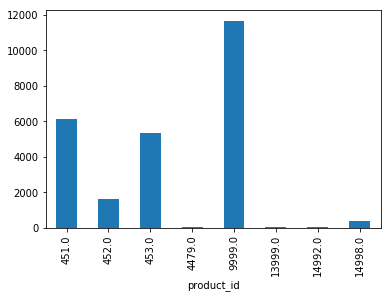

In [29]:
plot_count_per_id(transactions_mousse_tres_chocolates)

Interesting... Lets explore it more by having a look at the full distribution of names:

In [30]:
for i in transactions_mousse_tres_chocolates['product_id'].unique():
    to_print = df_with_normalized_descriptions_transactions[df_with_normalized_descriptions_transactions['product_id']==i]['desc_normalized'].value_counts().head()
    print("***Plotting id: {} ".format(i))
    print("-")

    print(to_print)
    print("")


***Plotting id: 9999.0 
-
encargo                       25745
julian de verduras             8246
julian de pimiento             8208
brandada de bacalao            6080
encargo julian de pimiento     5035
Name: desc_normalized, dtype: int64

***Plotting id: 451.0 
-
mousse 3 chocolates 2                   167333
mousse 3 chocolates 2 una de encargo       266
mousse 3 chocolates 4                      133
mousse 3 chocolates 2 encargo              133
mousse 3 chocolates 2 de encargo           114
Name: desc_normalized, dtype: int64

***Plotting id: 453.0 
-
mousse 3 chocolates 3               128003
mousse 3 chocolates 4                  589
mousse 3 chocolates 3 de encargo       190
mousse 3 chocolates del 4              190
mousse 3 chocolates 20rac              114
Name: desc_normalized, dtype: int64

***Plotting id: 452.0 
-
mousse 3 chocolates 1                                           121657
mousse 3 chocolates 1 de encargo                                    76
mousse 3 chocola

It seems that 'tarta mousse tres chocolates' is all over the place... So the easiest is to filter by product description"

In [31]:
mousse_tres_chocolates = filter_mousse_tres_chocolates(unique_normalized_decriptions)
mousse_tres_chocolates['target_names_prod_by_prod'] = 'mousse tres chocolates'
list_of_dfs.append(mousse_tres_chocolates)
mousse_tres_chocolates.head()

,product_id,desc_normalized,target_names_prod_by_prod
18867,9999.0,tarta mousse 3 chocolates 3 escrito sobre la t...,mousse tres chocolates
90355,9999.0,tarta mousse 3 chocolates del segun escrito so...,mousse tres chocolates
105628,451.0,mousse 3 chocolates 2 escrito sobre la tarta f...,mousse tres chocolates
105632,9999.0,encargo tarta mousse 3 chocolates del 4 sandra...,mousse tres chocolates
114166,451.0,mousse 3 chocolates 2 escrito sobre la tarta y...,mousse tres chocolates


#### 2.3.5 Matching: tarta de manzana 2
From the analysis performed in notebook "x01-transactions_to_partial_results-yy.ipynb", it was concluded that 'tarta de manzana 2' had no correlation with a particular product_id, therefore the analysis will be based on the description:

In [32]:
def filter_tarta_manzana_2 (df):
    manzana_tarta = df[df['desc_normalized'].str.contains('manzana')]
    #manzana_tarta = manzana[manzana['desc_normalized'].str.contains('tarta')].copy() #Removed because we saw it had better fit
    manzana_tarta = manzana_tarta[~manzana_tarta['desc_normalized'].str.contains('caramelo')].copy()
    manzana_tarta_dos = manzana_tarta[manzana_tarta['desc_normalized'].str.contains('dos|2')].copy()

    return manzana_tarta_dos

In [33]:
transactions_manzana_tarta_dos=filter_tarta_manzana_2(df_with_normalized_descriptions_transactions)

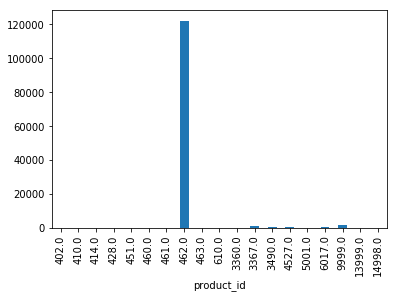

In [34]:
plot_count_per_id(transactions_manzana_tarta_dos)

Looks like we found a winner!

In [35]:
manzana_tarta_dos = filter_tarta_manzana_2(unique_normalized_decriptions)
manzana_tarta_dos['target_names_prod_by_prod'] = 'tarta de manzana'
list_of_dfs.append(manzana_tarta_dos)
manzana_tarta_dos.head()

,product_id,desc_normalized,target_names_prod_by_prod
11275,462.0,manzana 2,tarta de manzana
37483,5001.0,manzana caramelizados,tarta de manzana
96970,9999.0,encargotarta manzana del 2,tarta de manzana
219167,9999.0,encargo tarta manzana del 2,tarta de manzana
219790,462.0,manzana 2 cartelfelicidades inmanol,tarta de manzana


#### 2.3.6 Matching: palmera de chocolate 

In [36]:
def filter_palmera_chocolate (df):
    palmera = df[df['desc_normalized'].str.contains('palmera')]
    palmera_chocolate = palmera[palmera['desc_normalized'].str.contains('chocolate|trufa')].copy() #Added trufa after reviwing results
    return palmera_chocolate

In [37]:
transactions_palmera_chocolate = filter_palmera_chocolate(df_with_normalized_descriptions_transactions)
transactions_palmera_chocolate.head()

,product_id,description,order_date,section,store,units_ordered,desc_normalized
234,182.0,PALMERAS DE TRUFA,1/1/2008 0:00:00,0,VeUp,"4,00",palmera de trufa
1472,182.0,PALMERAS DE TRUFA,1/1/2008 0:00:00,0,ZiUO,"0,00",palmera de trufa
1595,182.0,PALMERAS DE TRUFA,1/1/2008 0:00:00,0,AeUP,"0,00",palmera de trufa
2637,182.0,PALMERAS DE TRUFA,1/1/2008 0:00:00,0,LiUP,"0,00",palmera de trufa
2831,182.0,PALMERAS DE TRUFA,1/1/2008 0:00:00,0,RzUP,"2,00",palmera de trufa


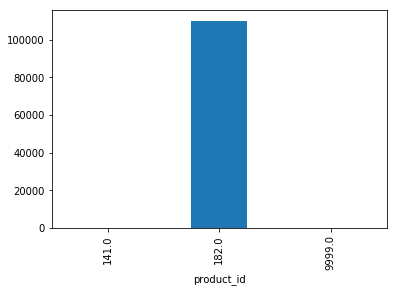

In [38]:
plot_count_per_id(transactions_palmera_chocolate)

Again, we have a winner!

In [39]:
palmera_chocolate = filter_palmera_chocolate(unique_normalized_decriptions)
palmera_chocolate['target_names_prod_by_prod'] = 'palmera chocolate'

list_of_dfs.append(palmera_chocolate)
palmera_chocolate.head()

,product_id,desc_normalized,target_names_prod_by_prod
234,182.0,palmera de trufa,palmera chocolate
147417,182.0,palmera de trufa (piezas),palmera chocolate
2838683,182.0,palmera de trufa manda con el furgon del pan,palmera chocolate
3710620,182.0,palmera de trufa y y unidades y y encargo para...,palmera chocolate
5182990,182.0,palmera de trufa primer duro n,palmera chocolate


#### 2.3.7 Matching: tarta ópera 

In [40]:
def filter_tarta_opera(df):
    opera = df[df['desc_normalized'].str.contains('opera')]
    opera_tarta = opera[opera['desc_normalized'].str.contains('tarta')].copy()
    return opera_tarta

In [41]:
transactions_tarta_opera = filter_tarta_opera(df_with_normalized_descriptions_transactions)

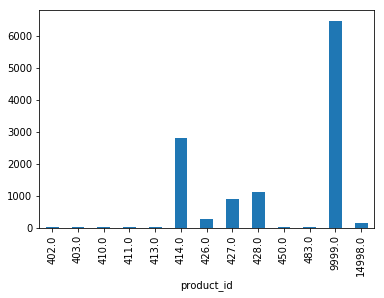

In [42]:
plot_count_per_id(transactions_tarta_opera)

In [43]:
for i in transactions_tarta_opera['product_id'].unique():
    to_print = df_with_normalized_descriptions_transactions[df_with_normalized_descriptions_transactions['product_id']==i]['desc_normalized'].value_counts().head()
    print("***Plotting id: {} ".format(i))
    print("-")

    print(to_print)
    print("")


***Plotting id: 9999.0 
-
encargo                       25745
julian de verduras             8246
julian de pimiento             8208
brandada de bacalao            6080
encargo julian de pimiento     5035
Name: desc_normalized, dtype: int64

***Plotting id: 414.0 
-
tarta muy tres chocolates 2    4788
tarta milhojas frambuesa 2     4123
tarta limon 3                  3420
tarta milhojas 2               1824
tarta tres chocolates 2        1805
Name: desc_normalized, dtype: int64

***Plotting id: 14998.0 
-
tarta mousse de tres chocolates del 4                                         38
tartas especiales                                                             38
tartas especiales de 10 de mickey de 12 la con el bizcocho de selva negra     38
tarta saint honore del 4                                                      38
tarta especial raspadura del 5 con dibujo en gelatina de princesas encargo    19
Name: desc_normalized, dtype: int64

***Plotting id: 427.0 
-
opera 3              

Again, all over the place, so we decided to use the description filter:

In [44]:
tarta_opera = filter_tarta_opera(unique_normalized_decriptions)
tarta_opera['target_names_prod_by_prod'] = 'tarta opera'

list_of_dfs.append(tarta_opera)
tarta_opera.head()

,product_id,desc_normalized,target_names_prod_by_prod
11188,9999.0,tarta opera del 3,tarta opera
18868,9999.0,tarta opera del 4,tarta opera
114409,414.0,tarta opera 2,tarta opera
276927,9999.0,encargo tarta opera del 5,tarta opera
276928,9999.0,encargo tarta opera del 8,tarta opera


#### 2.3.9 Matching: postre de fresas y mascarpone

In [45]:
def filter_postre_fresas_mascarpone (df):
    postre = df[df['desc_normalized'].str.contains('postre')]
    postre_fresa = postre[postre['desc_normalized'].str.contains('fresa')].copy()
    postre_fresa = postre_fresa[~postre['desc_normalized'].str.contains('eclair')].copy() #Client indication
    postre_fresa = postre_fresa[~postre['desc_normalized'].str.contains('tartaleta')].copy() #Client indication

    postre_fresa_mascarpone = postre_fresa[postre_fresa['desc_normalized'].str.contains('mascarpone')].copy()
    return postre_fresa_mascarpone

In [46]:
transactions_postre_fresas_mascarpone = filter_postre_fresas_mascarpone(df_with_normalized_descriptions_transactions)

/Users/miruiz/kschool-final-project/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/Users/miruiz/kschool-final-project/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


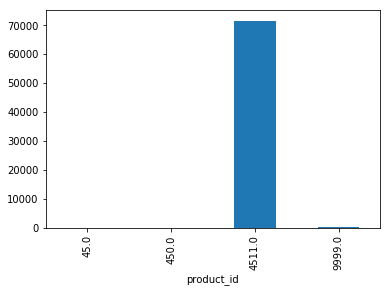

In [47]:
plot_count_per_id(transactions_postre_fresas_mascarpone)

In [48]:
for i in transactions_postre_fresas_mascarpone['product_id'].unique():
    to_print = df_with_normalized_descriptions_transactions[df_with_normalized_descriptions_transactions['product_id']==i]['desc_normalized'].value_counts().head()
    print("***Plotting id: {} ".format(i))
    print("-")

    print(to_print)
    print("")


***Plotting id: 4511.0 
-
postres fresas y mascarpone                                71402
postres tartaleta fresas y mascarpone                        684
postres fresas y mascarpone encargo line                      38
postres fresas y mascarpone encargo de                        38
postres fresas y mascarpone sin chocolatina de mallorca       19
Name: desc_normalized, dtype: int64

***Plotting id: 9999.0 
-
encargo                       25745
julian de verduras             8246
julian de pimiento             8208
brandada de bacalao            6080
encargo julian de pimiento     5035
Name: desc_normalized, dtype: int64

***Plotting id: 450.0 
-
postres mousse tres chocolates      82403
postres selva negra                  3116
postres milhojas frambuesa           2926
mini postres muy tres chocolates     2014
postres milhojas                     1976
Name: desc_normalized, dtype: int64

***Plotting id: 45.0 
-
postres mousse tres chocolates    34865
postres san marcos               

Seems that the filter is working :)

In [49]:
postre_fresas_mascarpone = filter_postre_fresas_mascarpone(unique_normalized_decriptions)

postre_fresas_mascarpone['target_names_prod_by_prod'] = 'postre de fresas y mascarpone'
list_of_dfs.append(postre_fresas_mascarpone)
postre_fresas_mascarpone.head()


/Users/miruiz/kschool-final-project/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/Users/miruiz/kschool-final-project/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


,product_id,desc_normalized,target_names_prod_by_prod
37190,4511.0,postres fresas y mascarpone,postre de fresas y mascarpone
1492120,9999.0,encargo 1 postres de cada de breton milhojas l...,postre de fresas y mascarpone
3710627,9999.0,encargo postres de fresa y mascarpone,postre de fresas y mascarpone
6574446,9999.0,postres fresa y mascarpone,postre de fresas y mascarpone
8328632,9999.0,encargopostre fresa y mascarpone,postre de fresas y mascarpone


#### 2.3.9 Matching: tortel

In [50]:
def filter_tortel (df):
    tortel = df[df['desc_normalized'].str.contains('tortel')].copy()
    tortel = tortel[~tortel['desc_normalized'].str.contains('tortellini|mini')].copy()

    return tortel

In [51]:
transactions_tortel = filter_tortel(df_with_normalized_descriptions_transactions)

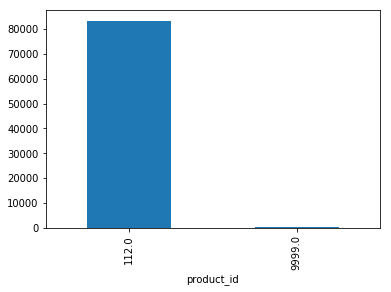

In [52]:
plot_count_per_id(transactions_tortel)

In [53]:
for i in transactions_tortel['product_id'].unique():
    to_print = df_with_normalized_descriptions_transactions[df_with_normalized_descriptions_transactions['product_id']==i]['desc_normalized'].value_counts().head()
    print("***Plotting id: {} ".format(i))
    print("-")

    print(to_print)
    print("")


***Plotting id: 112.0 
-
torteles                              82821
baguet multicereales                    437
ensaimadas piezas hacer a las 12 y      342
focaccias                               228
suizos piezas hacer las 12 y            209
Name: desc_normalized, dtype: int64

***Plotting id: 9999.0 
-
encargo                       25745
julian de verduras             8246
julian de pimiento             8208
brandada de bacalao            6080
encargo julian de pimiento     5035
Name: desc_normalized, dtype: int64



In [54]:
tortel = filter_tortel(unique_normalized_decriptions)

tortel['target_names_prod_by_prod'] = 'tortel'
list_of_dfs.append(tortel)
tortel.head(5)

,product_id,desc_normalized,target_names_prod_by_prod
272,112.0,torteles,tortel
609768,9999.0,encargo380 torteles cocido para las tres,tortel
617650,112.0,torteles para cartel 4 50 10,tortel
617651,112.0,torteles para miercoles 50 50 10,tortel
617652,112.0,torteles para verdes 7 50 10,tortel


#### 2.3.10 Matching: baguette

In [55]:
def filter_baguette (df):
    baguette = df[df['desc_normalized'].str.contains('baguette|baguete|baguet')].copy()
    return baguette

In [56]:
transaction_baguette = filter_baguette(df_with_normalized_descriptions_transactions)

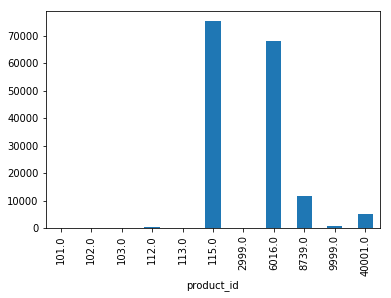

In [57]:
plot_count_per_id(transaction_baguette)

In [58]:
for i in transaction_baguette['product_id'].unique():
    to_print = df_with_normalized_descriptions_transactions[df_with_normalized_descriptions_transactions['product_id']==i]['desc_normalized'].value_counts().head()
    print("***Plotting id: {} ".format(i))
    print("-")

    print(to_print)
    print("")


***Plotting id: 115.0 
-
baguette mallorca                   47215
baguett mallorca                    28177
suizos piezas hacer a las 12 y         38
ensaimadas piezas hacer las 12 y       19
baguette mallorca cocido               19
Name: desc_normalized, dtype: int64

***Plotting id: 6016.0 
-
baguet piezas 5 hora          60306
baguet 5 la ana                7942
tartas pan torrijas andes        19
barritas integrales piezas       19
pan tostas tartas                19
Name: desc_normalized, dtype: int64

***Plotting id: 8739.0 
-
baguette mallorca integral    11552
lorena integral                9348
cold pan integral px             19
Name: desc_normalized, dtype: int64

***Plotting id: 103.0 
-
croissant petit                  94259
mini napolitanas crema            1824
mini napolitanas chocolate        1748
croissant normal petit            1216
croissant andes marcos piezas      380
Name: desc_normalized, dtype: int64

***Plotting id: 40001.0 
-
baguet    5149
Name: desc_norm

Per client indications we take id = 115.0 containing baguette

In [59]:
baguette = unique_normalized_decriptions[unique_normalized_decriptions['product_id']==115.0].copy()
baguette = baguette[baguette['desc_normalized'].str.contains('baguette|baguete|baguet')].copy()

baguette['target_names_prod_by_prod'] = 'baguette'
list_of_dfs.append(baguette)
baguette.head(5)

,product_id,desc_normalized,target_names_prod_by_prod
274,115.0,baguett mallorca,baguette
43592,115.0,baguette mallorca,baguette
19757224,115.0,baguette mallorca sin la bolsa mallorca,baguette
20766325,115.0,baguette mallorcasin bolsa mallorca,baguette
22770998,115.0,baguette mallorca cocido,baguette


### Lets now concatenate results, merge them back to the  full list of normalized descriptions and evaluate its effectiveness

In [60]:
# Lets concatenate the results:
list_of_products_df = pd.concat(list_of_dfs, sort=False)

In [61]:
list_of_products_df[list_of_products_df.duplicated()]

,product_id,desc_normalized,target_names_prod_by_prod


In [86]:
# Merging with transaction dataset
df_desc_normalezed_vs_prod_by_prod = pd.merge(df_with_normalized_descriptions_transactions, list_of_products_df[['desc_normalized','target_names_prod_by_prod']],how='left',on = ['desc_normalized','product_id'])

KeyError: 'product_id'

In [64]:
# Merging test:

In [65]:
#Control merge size:
if (df_with_normalized_descriptions_transactions.shape[0] == df_desc_normalezed_vs_prod_by_prod.shape[0] ): 
    test1 = "OK - 'df_with_normalized_descriptions_transactions' has the same size as 'df_with_normalized_descriptions_transactions' "
else:
    test1 = "ERROR - 'df' has NOT the same size as 'df_desc_normalezed_vs_prod_by_prod' "

print(test1)

ERROR - 'df' has NOT the same size as 'df_with_normalized_descriptions_transactions' 


*NOTE:*

During the first executions of code with the full transactions file, this error was failing; 'df' had less rows than 'df_with_normalized_descriptions_transactions'. The reason for this was not easy to identify, however digging we found that that in the normalized description two products descriptions ware naming two different products in the description, however this was not the case for the raw description (before the spell-cheacker):

for example:
- Normalized prod description: 'tarta mousse 3 chocolates de 20 raciones con escrito sobre la tarta manzana y mini felicidades'
- Raw description: 'TARTA MOUSSE 3 CHOCOLATES DE 20 RACIONES CON ESCRITO SOBRE LA TARTA:  MARIANA Y DANI FELICIDADES'

Basically, the spell-corrector was solving some problems; normalizing 'trata' , 'taaarta' under 'tarta', but adding a new one: normalizing words that it doesnt know, that may be a correct word, to a word that it knows: 'MARIANA' to 'manzana'... Ofcourse this is a weakness, however from the manual inspections that were performed, it doesnt seem to happen often.

How we solve it by adding to the bakery products dataset: 
- A list of the most common male and female spanish names: in order to avoid confusion in the names

sources of the datasets:
- spanish names:https://www.ine.es/dyngs/INEbase/es/operacion.htm?c=Estadistica_C&cid=1254736177009&menu=resultados&secc=1254736195454&idp=1254734710990


Also, in this case we added some names that we found to the excel; the right thing to do should we had more time, would be to polish the dataset, by adding not just mallorca catalogue and names, but also a book in spanish. Perhaps, it would also be interesting to applying NLP to identify NAMES from the product descriptions and add them to the products dataset...

Lets now check how effective it was:

In [66]:
# Lets look at the first 10 description names
df_desc_normalezed_vs_prod_by_prod[['desc_normalized','target_names_prod_by_prod']].head(10)

,desc_normalized,target_names_prod_by_prod
0,pechuga de rellena de higos y setas,NaN
1,surtido novedad 1 4 g,NaN
2,surtido novedad de 1 2 g,NaN
3,rollito de salmon del de mouselina de marcos,NaN
4,todos de alcachofas rellenos de mario,NaN
5,magret de pato con citricos,NaN
6,albondigas de carne,NaN
7,cordero al cherry,NaN
8,ensalada de pancitos con gambas,NaN
9,verduras salteadas con jamon,NaN


In [67]:
# Lets now review the effectiveness filtering by 'mousse '. The expected result is that all 'mousse 3 chocolates' match
df_desc_normalezed_vs_prod_by_prod.loc[df_desc_normalezed_vs_prod_by_prod['desc_normalized'].str.contains('mousse'),['desc_normalized','target_names_prod_by_prod'] ].head(15)

,desc_normalized,target_names_prod_by_prod
394,mousse chocolate blanco,NaN
528,postres mousse chocolate en vasito,NaN
530,postres mousse frutas bosque,NaN
599,postres mousse frutas bosque,NaN
601,postres mousse chocolate en vasito,NaN
667,postres mousse de limon,NaN
686,petit yogur mousse praline,NaN
1083,postres mousse frutas bosque,NaN
1085,postres mousse chocolate en vasito,NaN
1141,mousse 3 chocolates 3,NaN


This looks much better! lets now check that the data integrity has not been compromised

### 2.5 Test that data has not been corrputed

To test the integrity of the data, the original dataset should be the same as the last dataset without that we added, in other words, without the columns with the normalized descriptuons, and the target names:

In [68]:
# First, lets check the size of both dataframes:
print("Original dataset shape: {}".format(df.shape))
print("Resulting dataset shape: {}".format(df_desc_normalezed_vs_prod_by_prod.shape))

Original dataset shape: (30550252, 6)
Resulting dataset shape: (31136592, 8)


The shape looks good, we were expecting the resulting dataset to have to columns more. Lets now evauate if they are actually the same dataset if we remove the added columns:

In [69]:
# Selecting original columnsd from the resulting df
df_result = df_desc_normalezed_vs_prod_by_prod.loc[:, df.columns]

In [70]:
# Now, lets compare it with the original dataset, sorting them out in the same way:
df_result_sorted = df_result.sort_values(by = ['order_date','store','description','product_id', 'units_ordered']).reset_index().drop('index', axis = 1)
df_original_sorted = df.sort_values(by = ['order_date','store','description',  'product_id', 'units_ordered']).reset_index().drop('index', axis = 1)

In [71]:
df_result_sorted.head()

,product_id,description,order_date,section,store,units_ordered
0,615.0,ALASKAS FRAMBUESA,1/1/2008 0:00:00,0,AaUP,"2,00"
1,172.0,1/2 PAN DE MOLDE ENVUELTO,1/1/2008 0:00:00,0,AaUP,"0,00"
2,9999.0,3 RACIONES DE ENSALADA DE CAPON,1/1/2008 0:00:00,0,AaUP,"0,00"
3,9999.0,3 RACIONES VERDURAS SALTEADAS,1/1/2008 0:00:00,0,AaUP,"0,00"
4,3252.0,ACETATO 11 POOL NUEVO,1/1/2008 0:00:00,0,AaUP,"0,00"


In [72]:
df_original_sorted.head()

,product_id,description,order_date,section,store,units_ordered
0,615.0,ALASKAS FRAMBUESA,1/1/2008 0:00:00,0,AaUP,"2,00"
1,172.0,1/2 PAN DE MOLDE ENVUELTO,1/1/2008 0:00:00,0,AaUP,"0,00"
2,9999.0,3 RACIONES DE ENSALADA DE CAPON,1/1/2008 0:00:00,0,AaUP,"0,00"
3,9999.0,3 RACIONES VERDURAS SALTEADAS,1/1/2008 0:00:00,0,AaUP,"0,00"
4,3252.0,ACETATO 11 POOL NUEVO,1/1/2008 0:00:00,0,AaUP,"0,00"


In [73]:
# Now that they have the same columns, and are sorted using the same criteria, lets evaluate if they are the same:
comparison_result = df_result_sorted.equals(df_original_sorted)

if comparison_result == True:
    test2 = 'OK - The original dataset is the similar to the resulting dataset'
else:
     test2 ='ERROR - The original dataset are NOT found'

print(test2)

ERROR - The original dataset are NOT found


### 2.6 Filter dataset to only include the products from the list provided by the client, and save to csv

In [74]:
df_target_products = df_desc_normalezed_vs_prod_by_prod[~df_desc_normalezed_vs_prod_by_prod['target_names_prod_by_prod'].isnull()]
df_other_products = df_desc_normalezed_vs_prod_by_prod[df_desc_normalezed_vs_prod_by_prod['target_names_prod_by_prod'].isnull()]

In [75]:
df_target_products_file_name = exit_path + 'filtered_transactions_not_clean.csv' 
df_target_products.to_csv(df_target_products_file_name, index = False, sep = ';' )
df_target_products.head()

,product_id,description,order_date,section,store,units_ordered,desc_normalized,target_names_prod_by_prod
216,100.0,CROISANTS,1/1/2008 0:00:00,0,VeUp,"20,00",croissant,croissant simple
217,100.0,CROISANTS,1/1/2008 0:00:00,0,VeUp,"20,00",croissant,croissant simple
235,182.0,PALMERAS DE TRUFA,1/1/2008 0:00:00,0,VeUp,"4,00",palmera de trufa,palmera chocolate
236,182.0,PALMERAS DE TRUFA,1/1/2008 0:00:00,0,VeUp,"4,00",palmera de trufa,palmera chocolate
242,101.0,CROISSANT,1/1/2008 0:00:00,0,VeUp,"0,00",croissant,croissant simple


In [76]:
unfiltered_products_file_name = exit_path + 'unfiltered_transactions.csv' 
df_other_products.to_csv(unfiltered_products_file_name, index = False, sep = ';' )
df_other_products.head()

KeyboardInterrupt: 

# ERROR CONTROL

In [78]:
#print(test0)
print(test1)
print(test2)

ERROR - 'df' has NOT the same size as 'df_with_normalized_descriptions_transactions' 
ERROR - The original dataset are NOT found


FALTARIA LIMPIAR EL DATASET